In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl

import time
import pickle

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [3]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [61]:
%load_ext autoreload
%autoreload 2

from pubmed_landscape_src.plotting import (
    improved_coloring,
    plot_tsne_colors,
    plot_label_tags,
)
from pubmed_landscape_src.exploration import (
    print_tfidf_top_words,
    print_tfidf_threshold_words,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
variables_path = Path("../../results/variables/2024_baseline")
figures_path = Path("../../results/figures/2024_baseline")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [6]:
plt.style.use("../matplotlib_style.txt")

# Import

In [7]:
%%time
%%memit
# import clean_2024_df

clean_2024_df = pd.read_pickle(variables_path / "clean_2024_df")

peak memory: 66825.37 MiB, increment: 66409.89 MiB
CPU times: user 59.8 s, sys: 42.5 s, total: 1min 42s
Wall time: 1min 42s


In [8]:
clean_2024_df.tail()

PMID                                              Title  \
36555425  38096615      Does muscle-type myosin have ADPase activity?   
36555426  38096616  NDUFA8 is transcriptionally regulated by EP300...   
36555427  38096617  Nardilysin determines hematopoietic stem cell ...   
36555428  38096618  The role of integrin αvβ3 in biphasic calcium ...   
36555429  38096619  Risk prediction models for postoperative delir...   

                                               AbstractText Language  \
36555425  Adenosine diphosphate (ADP) is a nucleotide th...      eng   
36555426  Cervical cancer, a common malignancy in women,...      eng   
36555427  Nardilysin (NRDC) is a multifunctional protein...      eng   
36555428  Calcium phosphate ceramics-based biomaterials ...      eng   
36555429  Elderly patients with fragility hip fracture c...      eng   

                                                    Journal         Date  \
36555425  Biochemical and biophysical research communica...  2023 Dec 09   
36555426  Biochemical and biophysical research communica...  2023 Dec 10   
36555427  Biochemical and biophysical research communica...  2023 Dec 06   
36555428                                       Biomaterials  2023 Dec 01   
36555429  International journal of orthopaedic and traum...  2023 Dec 10   

         NameFirstAuthor NameLastAuthor       ISSN  \
36555425          Ilya G   Vyacheslav A  1090-2104   
36555426          Huaguo       Yingzhen  1090-2104   
36555427      Shinichiro            Ryo  1090-2104   
36555428        Hanghang             En  1878-5905   
36555429        Bingqian           Hong  1878-1292   

                                     AffiliationFirstAuthor  \
36555425  Laboratory of Cell Biophysics, A.V. Zhirmunsky...   
36555426  Department of Clinical Laboratory, Fuyong Peop...   
36555427  Department of Hematology and Oncology, Graduat...   
36555428  State Key Laboratory of Oral Diseases & Nation...   
36555429  Tianjin University of Traditional Chinese Medi...   

                                      AffiliationLastAuthor           filename  
36555425  Laboratory of Cell Biophysics, A.V. Zhirmunsky...  pubmed24n1219.xml  
36555426  Department of Clinical Laboratory, Fuyong Peop...  pubmed24n1219.xml  
36555427  Institute for the Advanced Study of Human Biol...  pubmed24n1219.xml  
36555428  State Key Laboratory of Oral Diseases & Nation...  pubmed24n1219.xml  
36555429  Tianjin Hospital Trauma Upper Extremity Ward I...  pubmed24n1219.xml

In [9]:
tsne = np.load(variables_path / "tsne_bert_sep.npy")

In [10]:
tsne_rot = np.vstack((-tsne[:, 1], -tsne[:, 0])).T

# Covid-19 papers

In [10]:
titles = clean_2024_df["AbstractText"]
sub1 = "covid-19"
sub2 = "COVID-19"
sub3 = "Covid-19"
sub4 = "CoViD-19"
sub5 = "2019-nCoV"
sub6 = "SARS-CoV-2"
sub7 = "coronavirus disease 2019"
sub8 = "Coronavirus disease 2019"

indexes1 = titles.str.find(sub1)
indexes2 = titles.str.find(sub2)
indexes3 = titles.str.find(sub3)
indexes4 = titles.str.find(sub4)
indexes5 = titles.str.find(sub5)
indexes6 = titles.str.find(sub6)
indexes7 = titles.str.find(sub7)
indexes8 = titles.str.find(sub8)

mask_covid_2 = (
    (indexes1 != -1)
    | (indexes2 != -1)
    | (indexes3 != -1)
    | (indexes4 != -1)
    | (indexes5 != -1)
    | (indexes6 != -1)
    | (indexes7 != -1)
    | (indexes8 != -1)
)

# information
non_1_1 = indexes1[indexes1 != -1]
print("Number of titles with word 1: ", len(non_1_1))
non_1_2 = indexes2[indexes2 != -1]
print("Number of titles with word 2: ", len(non_1_2))
non_1_3 = indexes2[indexes3 != -1]
print("Number of titles with word 3: ", len(non_1_3))
non_1_4 = indexes2[indexes4 != -1]
print("Number of titles with word 4: ", len(non_1_4))
non_1_5 = indexes2[indexes5 != -1]
print("Number of titles with word 5: ", len(non_1_5))
non_1_6 = indexes2[indexes6 != -1]
print("Number of titles with word 6: ", len(non_1_6))
non_1_7 = indexes2[indexes7 != -1]
print("Number of titles with word 7: ", len(non_1_7))
non_1_8 = indexes2[indexes8 != -1]
print("Number of titles with word 8: ", len(non_1_8))

nsc_titles_word = titles[
    (indexes1 != -1)
    | (indexes2 != -1)
    | (indexes3 != -1)
    | (indexes4 != -1)
    | (indexes5 != -1)
    | (indexes6 != -1)
    | (indexes7 != -1)
    | (indexes8 != -1)
]
print("Number of titles with word: ", len(nsc_titles_word))

Number of titles with word 1:  1146
Number of titles with word 2:  251827
Number of titles with word 3:  9215
Number of titles with word 4:  90
Number of titles with word 5:  1129
Number of titles with word 6:  93616
Number of titles with word 7:  41547
Number of titles with word 8:  8287
Number of titles with word:  290285


In [11]:
np.save(variables_path / "mask_covid_2", mask_covid_2)

In [6]:
mask_covid_2 = np.load(variables_path / "mask_covid_2.npy")

## Plot

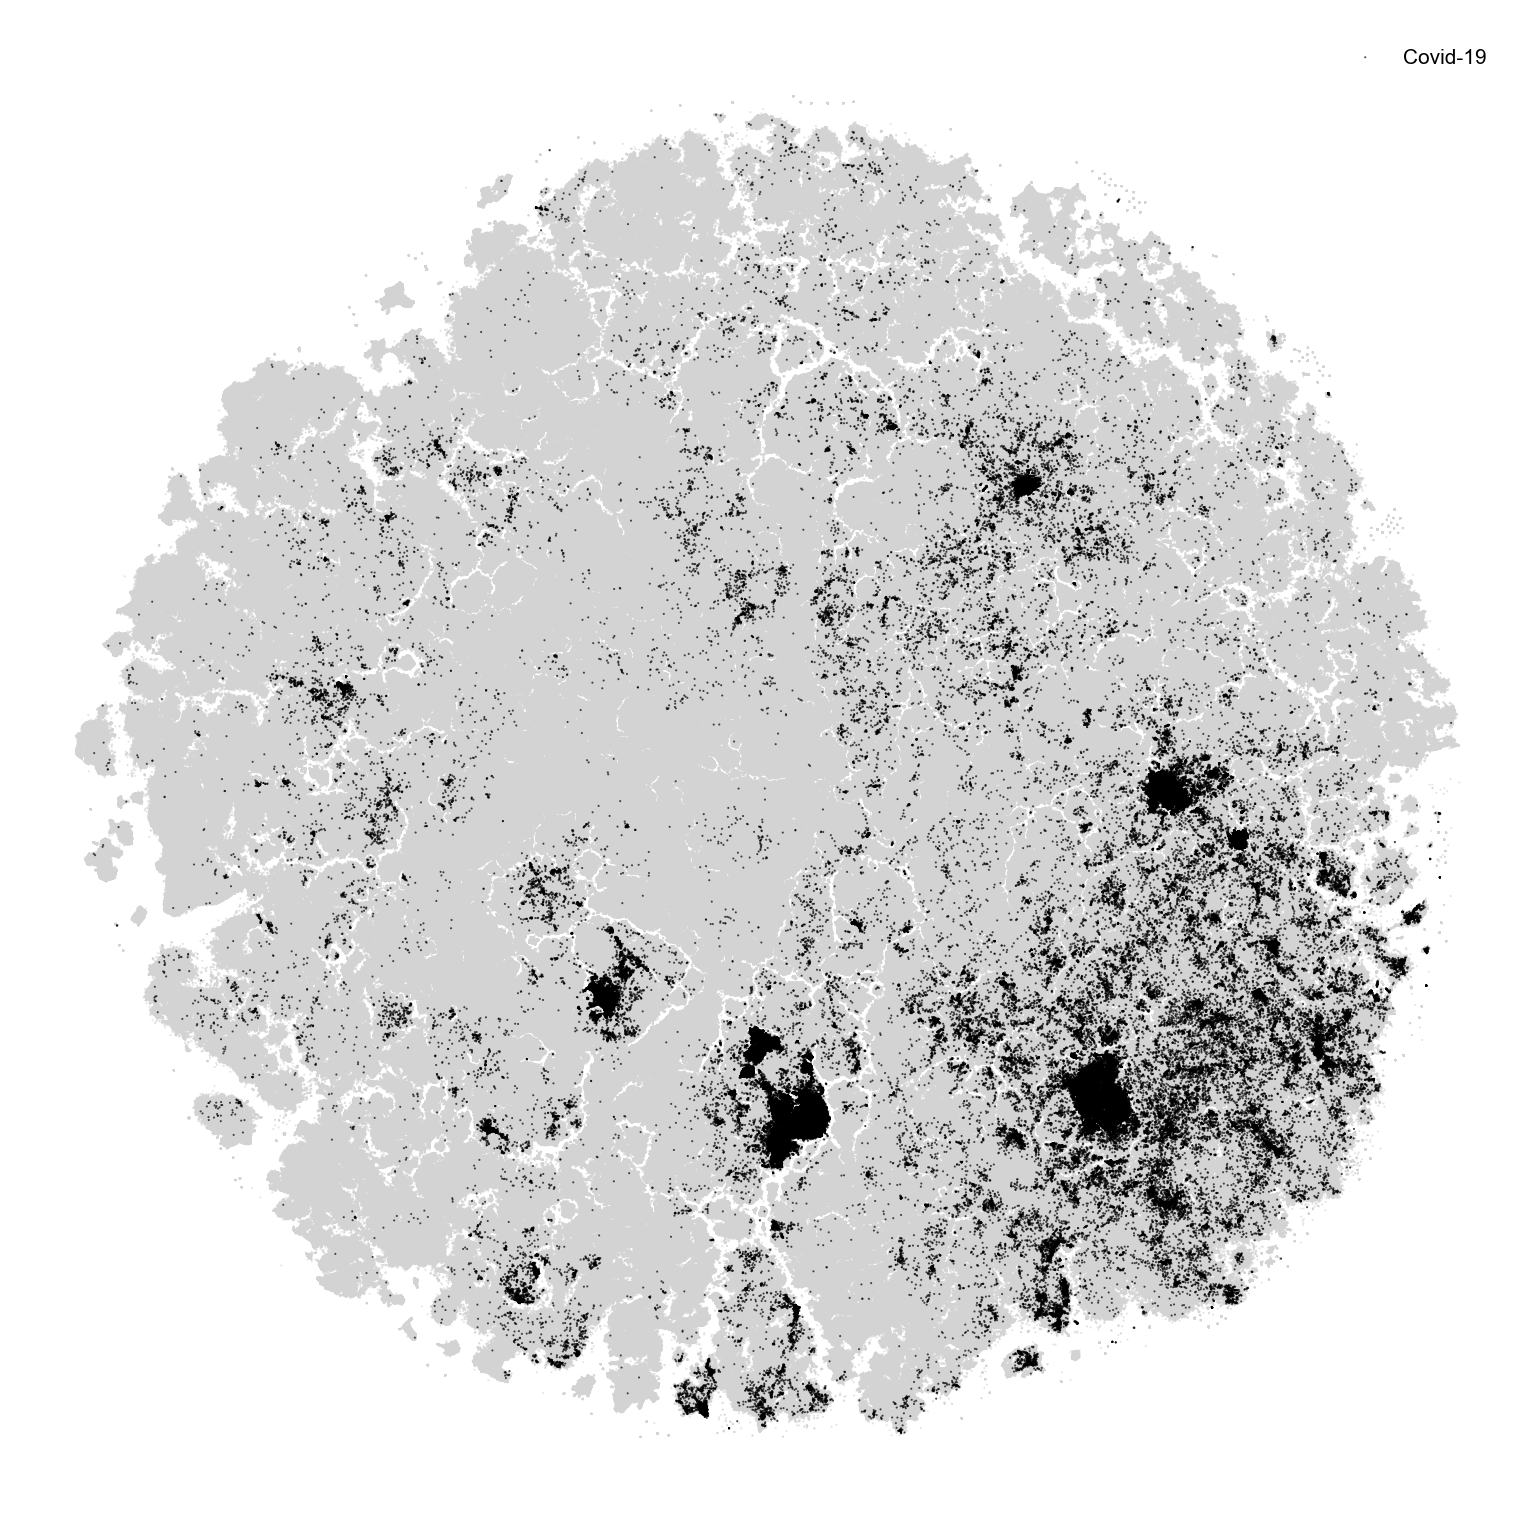

In [15]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
x_lim = (-230, 230)
y_lim = (-230, 230)

s_grey = 1
s_color = 1
alpha_grey = 0.6
alpha_color = 0.7


ax.scatter(
    *tsne_rot.T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)


ax.scatter(
    *tsne_rot[mask_covid_2].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
    label="Covid-19",
)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.legend()
ax.axis("equal")
ax.axis("off")

fig.savefig(figures_path / "tsne_covid_v2.png")

# Colors based on title keywords

## Colors

In [21]:
covid_words = [
    "Cancer",
    "Children",
    "Treatment",
    "Mental",
    "Mortality",
    "Transmission",
    "Psychological",
    "Workers",
    "Pneumonia",
    "Pediatric",
    "Healthcare",
    "Vaccine",
    "Outbreak",
    "Implications",
    "Strategies",
    "Clinical",
    "Epidemic",
    "Symptoms",
    "Respiratory",
    "Therapy",
    "Surgery",
    "Population",
    "Social",
    "Anxiety",
    "Students",
    "Antibody",
    "Immune",
]
cov_colors = [
    "#ffbe00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#5A0007",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#7B4F4B",
    "#0AA6D8",
    "#00846F",
]

In [22]:
covid_legend = dict(zip(covid_words, cov_colors))

In [21]:
%%time
covid_titles = clean_2024_df["Title"][mask_covid_2]
_, covid_colors = improved_coloring(covid_titles, covid_legend)

CPU times: user 11.3 s, sys: 156 ms, total: 11.5 s
Wall time: 11.5 s


In [23]:
# save results
np.save(variables_path / "covid_colors", covid_colors)

# save results
f = open(variables_path / "covid_legend.pkl", "wb")
pickle.dump(covid_legend, f)
f.close()

### Plot

In [13]:
# load results
covid_colors = np.load(variables_path / "covid_colors.npy", allow_pickle=True)

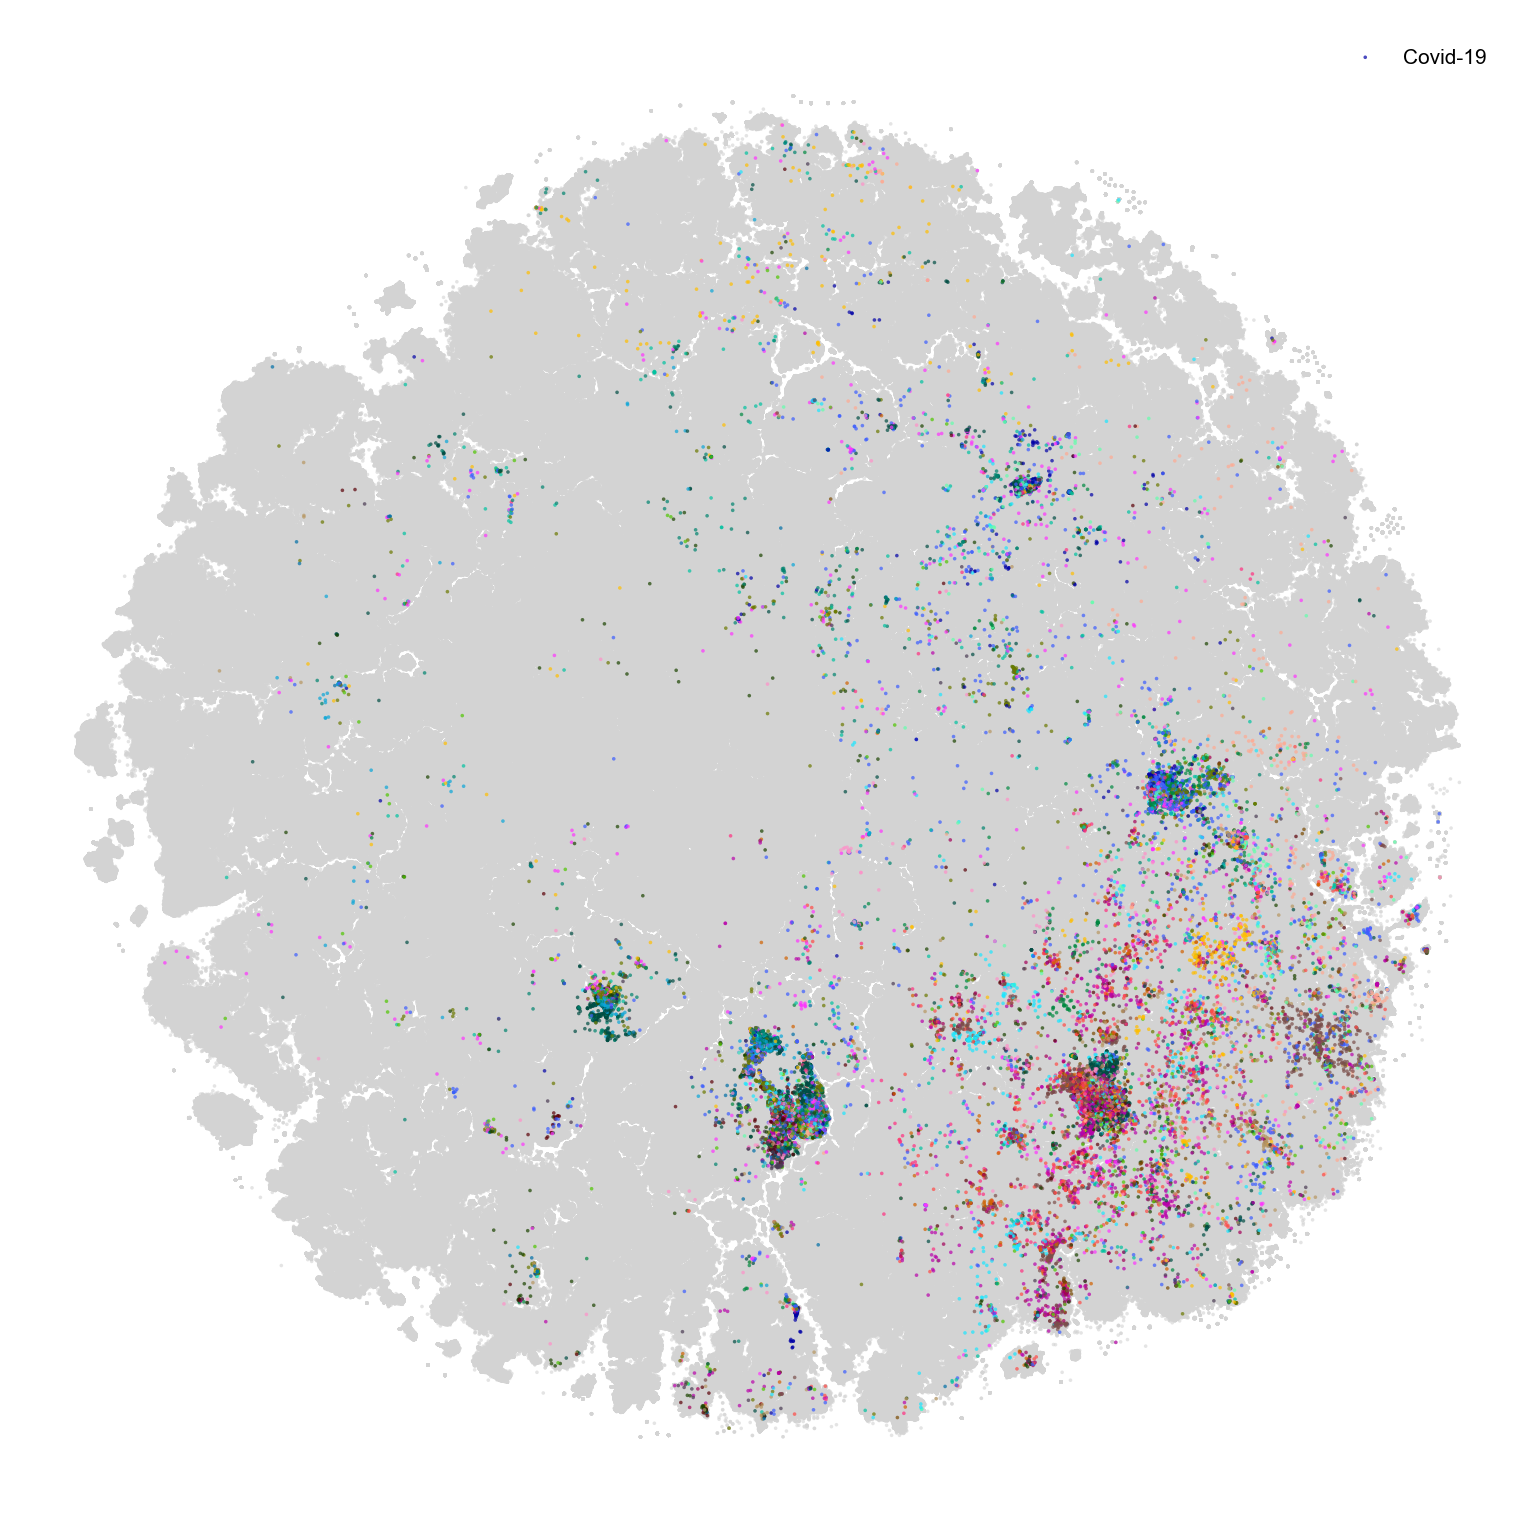

In [16]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
x_lim = (-230, 230)
y_lim = (-230, 230)

s_grey = 3
s_color = 3
alpha_grey = 0.6
alpha_color = 0.7


ax.scatter(
    *tsne_rot.T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)


ax.scatter(
    *tsne_rot[mask_covid_2][covid_colors != "lightgrey"].T,
    s=s_color,
    c=covid_colors[covid_colors != "lightgrey"],
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
    label="Covid-19",
)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.legend()
ax.axis("equal")
ax.axis("off")

fig.savefig(figures_path / "tsne_covid_v3.png")

# Exploration of fragmented old Covid-19 island

In [20]:
# save
date_year = np.load(variables_path / "date_year_2024.npy")

In [22]:
print("Total number of Covid-19 papers:", np.sum(mask_covid_2))
print(
    "Percentage of Covid-19 papers:",
    np.sum(mask_covid_2) / tsne.shape[0] * 100,
)

print(
    "Percentage of Covid-19 papers out of papers published in 2020-2024:",
    np.sum(mask_covid_2)
    / np.sum([(date_year >= 2020) & (date_year <= 2024)])
    * 100,
)

Total number of Covid-19 papers: 290285
Percentage of Covid-19 papers: 1.2411132150841486
Percentage of Covid-19 papers out of papers published in 2020-2024: 5.529720497521498


### Islands

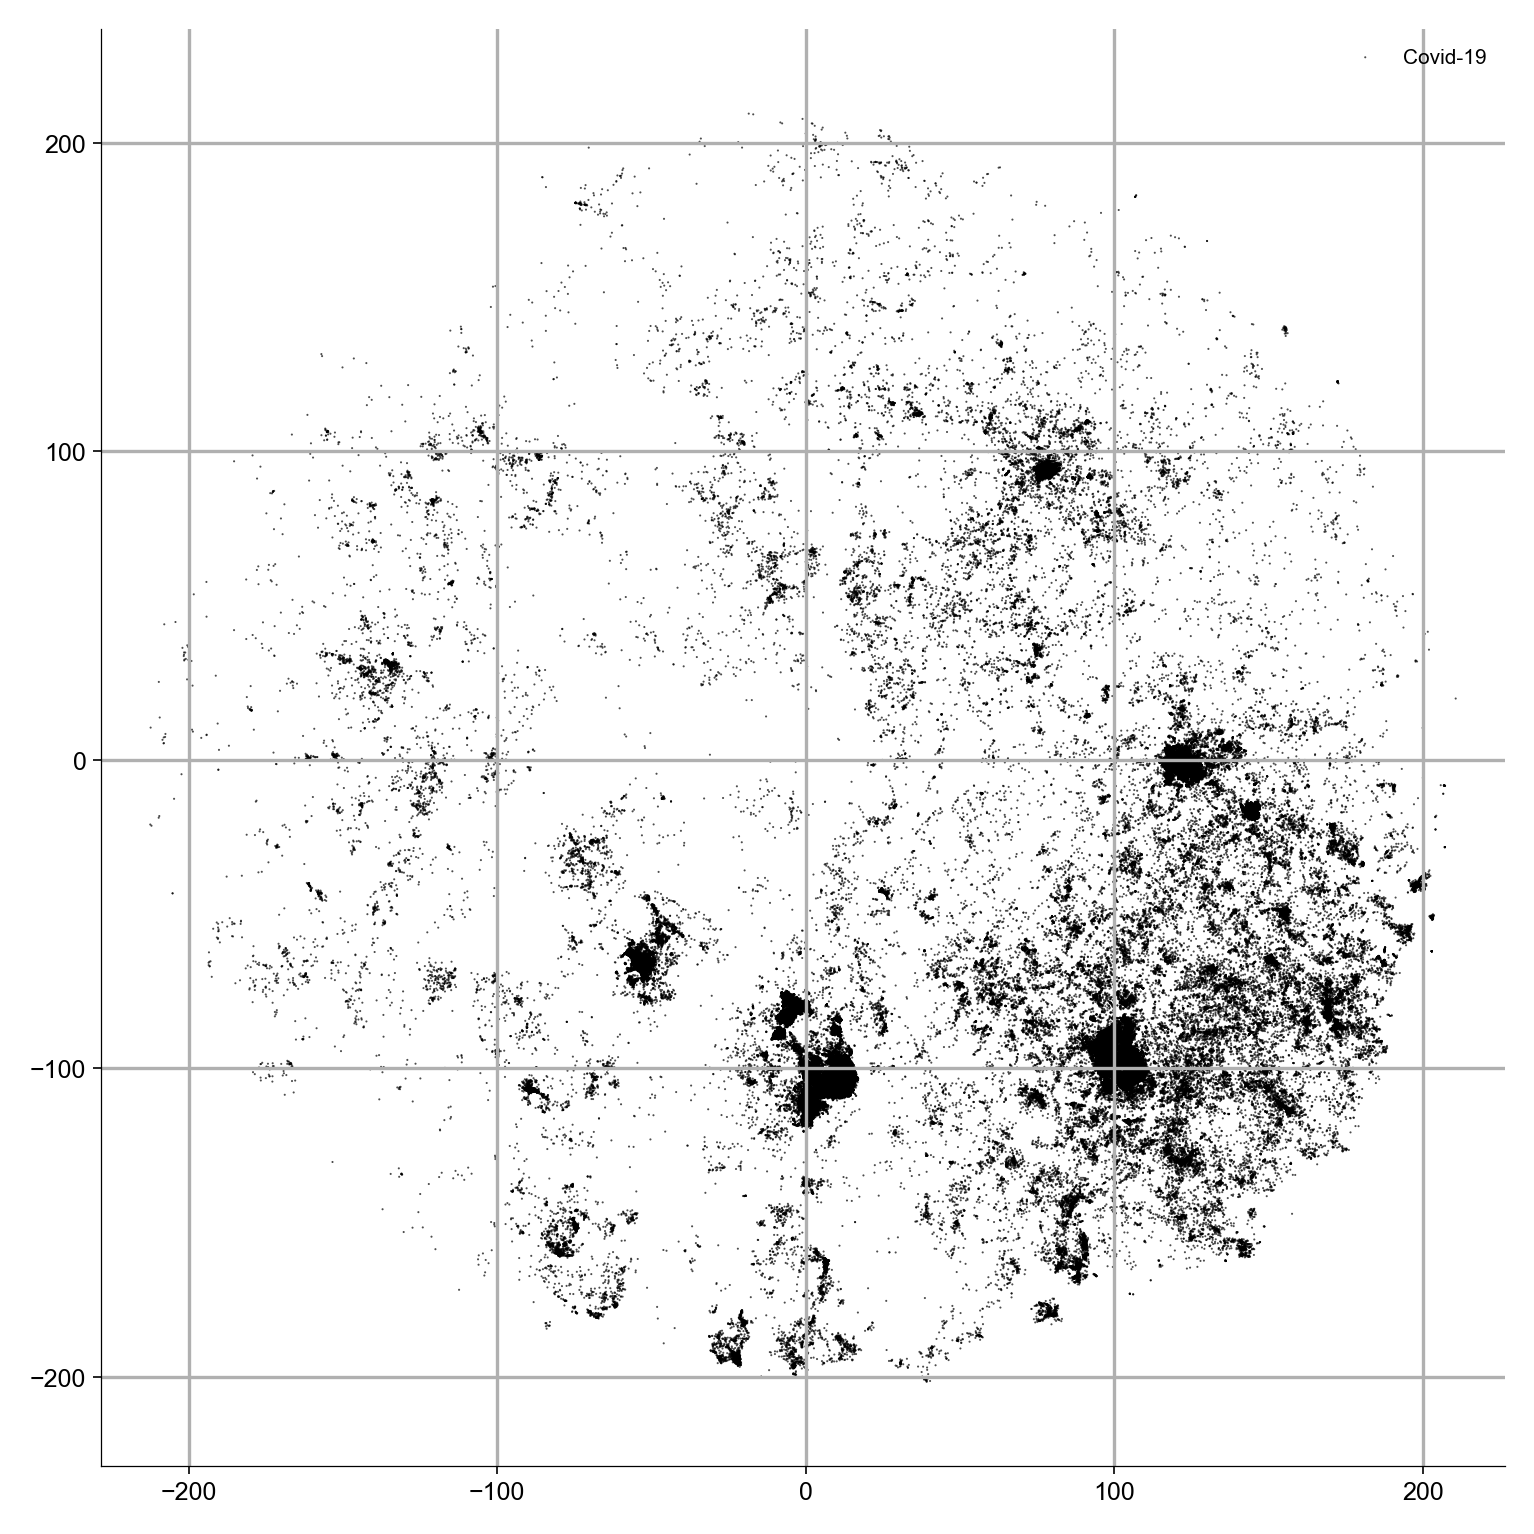

In [19]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
x_lim = (-230, 230)
y_lim = (-230, 230)

s_grey = 1
s_color = 1
alpha_grey = 0.6
alpha_color = 0.7


# ax.scatter(
#     *tsne_rot.T,
#     s=s_grey,
#     c="lightgrey",
#     alpha=alpha_grey,
#     marker=".",
#     ec="None",
#     rasterized=True,
# )


ax.scatter(
    *tsne_rot[mask_covid_2].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
    label="Covid-19",
)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.legend()
ax.axis("equal")
ax.grid()

In [40]:
# mask island 1
tsne = tsne_rot

right = 25
left = -25
top = -70
bottom = -130

mask_covid_island = (
    mask_covid_2
    & (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

In [41]:
print(
    "Number of Covid-19 papers grouped in the Covid island:",
    np.sum(mask_covid_island),
)
print(
    "Percentage of Covid-19 papers grouped in the Covid island:",
    np.sum(mask_covid_island) / np.sum(mask_covid_2) * 100,
)

Number of Covid-19 papers grouped in the Covid island: 84630
Percentage of Covid-19 papers grouped in the Covid island: 29.154107170539294


In [47]:
# mask island 2
tsne = tsne_rot

right = 120
left = 80
top = -70
bottom = -130

mask_covid_island = (
    mask_covid_2
    & (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

In [48]:
print(
    "Number of Covid-19 papers grouped in the Covid island:",
    np.sum(mask_covid_island),
)
print(
    "Percentage of Covid-19 papers grouped in the Covid island:",
    np.sum(mask_covid_island) / np.sum(mask_covid_2) * 100,
)

Number of Covid-19 papers grouped in the Covid island: 65257
Percentage of Covid-19 papers grouped in the Covid island: 22.480321063782142


In [50]:
# mask island 1
tsne = tsne_rot

right = 150
left = 110
top = 20
bottom = -20

mask_covid_island = (
    mask_covid_2
    & (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

In [51]:
print(
    "Number of Covid-19 papers grouped in the Covid island:",
    np.sum(mask_covid_island),
)
print(
    "Percentage of Covid-19 papers grouped in the Covid island:",
    np.sum(mask_covid_island) / np.sum(mask_covid_2) * 100,
)

Number of Covid-19 papers grouped in the Covid island: 39404
Percentage of Covid-19 papers grouped in the Covid island: 13.574245999621063


### Exploration of two gree-blue islands

In [11]:
mask_covid_2 = np.load(variables_path / "mask_covid_2.npy")

In [31]:
# load results
covid_colors = np.load(variables_path / "covid_colors.npy", allow_pickle=True)

pickle_in = open(variables_path / "covid_legend.pkl", "rb")
covid_legend = pickle.load(pickle_in)

In [32]:
inv_covid_legend = {v: k for k, v in covid_legend.items()}
inv_covid_legend["lightgrey"] = "Unlabeled"
inv_covid_legend

{'#ffbe00': 'Cancer',
 '#1CE6FF': 'Children',
 '#FF34FF': 'Treatment',
 '#FF4A46': 'Mental',
 '#008941': 'Mortality',
 '#006FA6': 'Transmission',
 '#A30059': 'Psychological',
 '#7A4900': 'Workers',
 '#0000A6': 'Pneumonia',
 '#63FFAC': 'Pediatric',
 '#B79762': 'Healthcare',
 '#004D43': 'Vaccine',
 '#5A0007': 'Outbreak',
 '#1B4400': 'Implications',
 '#4FC601': 'Strategies',
 '#3B5DFF': 'Clinical',
 '#4A3B53': 'Epidemic',
 '#FF2F80': 'Symptoms',
 '#6B7900': 'Respiratory',
 '#00C2A0': 'Therapy',
 '#FFAA92': 'Surgery',
 '#FF90C9': 'Population',
 '#B903AA': 'Social',
 '#D16100': 'Anxiety',
 '#7B4F4B': 'Students',
 '#0AA6D8': 'Antibody',
 '#00846F': 'Immune',
 'lightgrey': 'Unlabeled'}

In [25]:
covid_colors.shape

(290285,)

#### Island 1

In [27]:
# mask island 1
tsne = tsne_rot

right = 25
left = -25
top = -70
bottom = -130

mask_covid_island_1 = (
    mask_covid_2
    & (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

tsne_covid = tsne[mask_covid_2]
mask_island_1 = (
    (tsne_covid[:, 0] < right)
    & (tsne_covid[:, 0] > left)
    & (tsne_covid[:, 1] < top)
    & (tsne_covid[:, 1] > bottom)
)

In [39]:
print(clean_2024_df.Title[mask_covid_island_1].shape)
print(covid_colors[mask_island_1].shape)

(84630,)
(84630,)


In [41]:
n = 10
np.random.seed(42)
test = np.random.choice(
    covid_colors[mask_island_1].shape[0], size=n, replace=False
)

for i in test:
    print(clean_2024_df.Title[mask_covid_island_1].iloc[i])
    print(inv_covid_legend[covid_colors[mask_island_1][i]])
    # print(clean_2024_df.AbstractText[mask_covid_island_1].iloc[i])
    print("------------------")

Timing of State and Territorial COVID-19 Stay-at-Home Orders and Changes in Population Movement - United States, March 1-May 31, 2020.
Population
------------------
Mapping monoclonal anti-SARS-CoV-2 antibody repertoires against diverse coronavirus antigens.
Unlabeled
------------------
Clinical applications of detecting IgG, IgM or IgA antibody for the diagnosis of COVID-19: A meta-analysis and systematic review.
Clinical
------------------
Increased viral load in patients infected with severe acute respiratory syndrome coronavirus 2 Omicron variant in the Republic of Korea.
Unlabeled
------------------
The optimal lockdown intensity for COVID-19.
Unlabeled
------------------
Neutralizing Activity Against SARS-CoV-2 Delta and Omicron Variants Following a Third BNT162b2 Booster Dose According to Three Homologous or Heterologous COVID-19 Vaccination Schedules.
Unlabeled
------------------
Seroprevalence of SARS-CoV-2, Symptom Profiles and Sero-Neutralization in a Suburban Area, France.


In [44]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_island_1 = vectorizer.fit_transform(
    clean_2024_df.AbstractText[mask_covid_island_1]
)

vocabulary_island_1 = vectorizer.vocabulary_


NameError: name 'inv_vocabulary_island_1' is not defined

In [46]:
inv_vocabulary_island_1 = {v: k for k, v in vocabulary_island_1.items()}

In [49]:
print_tfidf_threshold_words(
    tfidf_island_1,
    inv_vocabulary_island_1,
    np.ones(tfidf_island_1.shape[0], dtype=bool),
    20,
    several_th=False,
)

There are 84630 papers.
In this threshold there are 84630 papers.
For threshold = 0.10 [3443 3301 3292 2911 2904 2887 2625 2612 2581 2523 2476 2343 2275 2256
 2220 2198 2196 2159 2105 2041]
For threshold = 0.10 ['vaccination' 'ci' 'vaccine' 'antibody' 'igg' '95' 'children' 'model'
 'dose' 'vaccines' 'omicron' 'variants' 'cells' 'antibodies' 'pcr' 'rt'
 'cell' 'anti' 'variant' 'testing']


In [63]:
print(tsne_covid[mask_island_1].shape)
print(covid_colors[mask_island_1].shape)

(84630, 2)
(84630,)


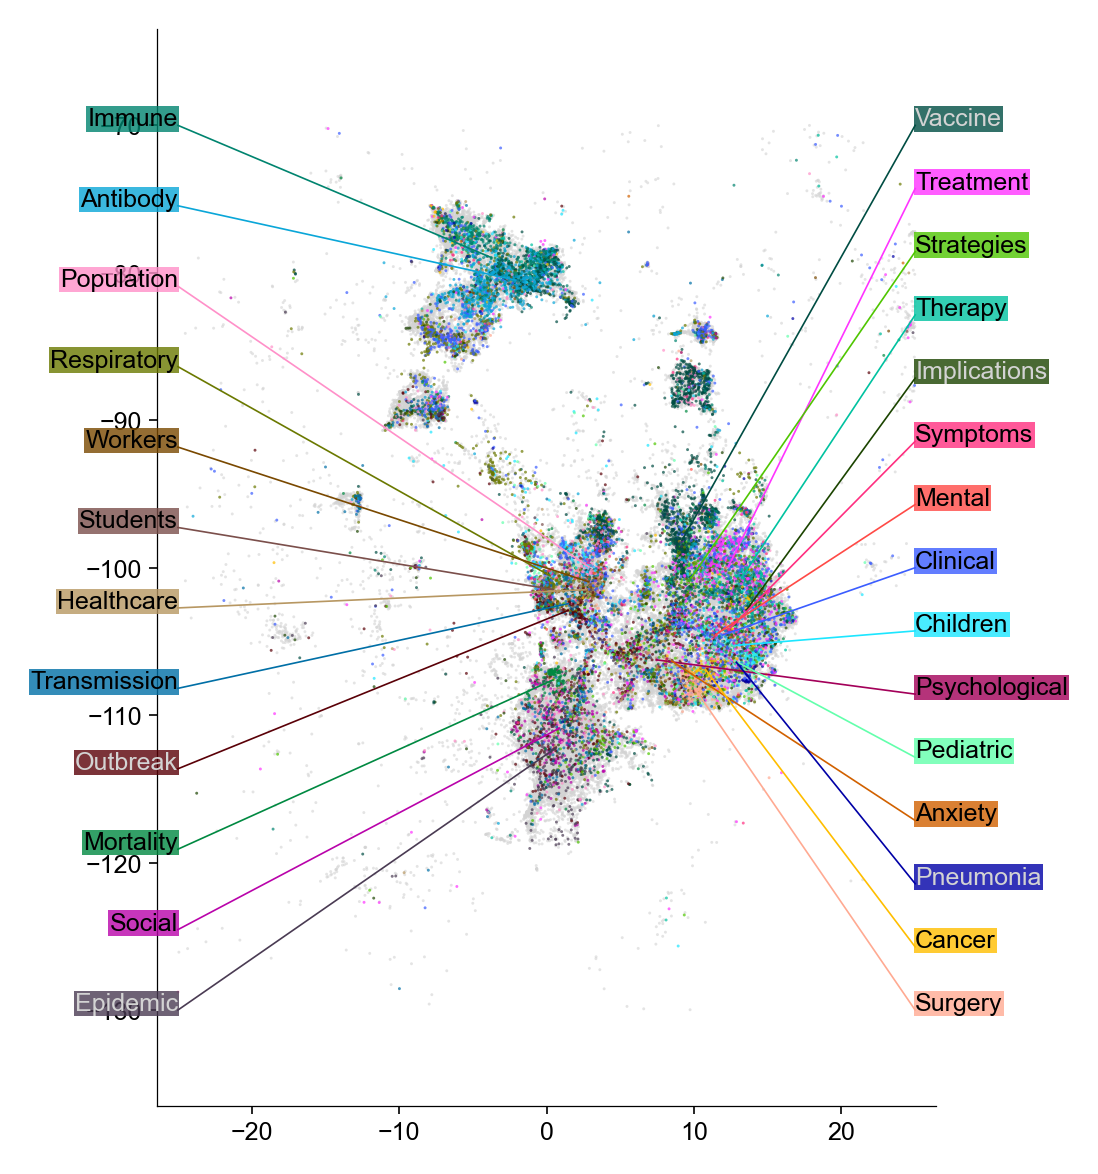

In [78]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.5, 3.8), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

tsne_subregion = tsne_covid[mask_island_1]
colors_subregion = covid_colors[mask_island_1]

right = 25
left = -25
top = -70
bottom = -130

x_lim = (left, right)
y_lim = (bottom, top)

plot_tsne_colors(
    tsne_subregion,
    colors_subregion,
    x_lim,
    y_lim,
    ax=ax,
    plot_type="test",
    axis_on=True,
)
plot_label_tags(
    tsne_subregion,
    colors_subregion,
    covid_legend,
    x_lim,
    y_lim,
    ax=ax,
    middle_value=6,
    fontsize=6,
    subset=False,
)

# fig.savefig(figures_path / "fig_2_covid.png")
# fig.savefig(figures_path / "fig_2_covid.pdf")

In [79]:
# mask island 1
tsne = tsne_rot

right = 25
left = -25
top = -95
bottom = -130

mask_covid_island_1 = (
    mask_covid_2
    & (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

tsne_covid = tsne[mask_covid_2]
mask_island_1 = (
    (tsne_covid[:, 0] < right)
    & (tsne_covid[:, 0] > left)
    & (tsne_covid[:, 1] < top)
    & (tsne_covid[:, 1] > bottom)
)

In [80]:
print(clean_2024_df.Title[mask_covid_island_1].shape)
print(covid_colors[mask_island_1].shape)

(59147,)
(59147,)


In [81]:
n = 10
np.random.seed(42)
test = np.random.choice(
    covid_colors[mask_island_1].shape[0], size=n, replace=False
)

for i in test:
    print(clean_2024_df.Title[mask_covid_island_1].iloc[i])
    print(inv_covid_legend[covid_colors[mask_island_1][i]])
    # print(clean_2024_df.AbstractText[mask_covid_island_1].iloc[i])
    print("------------------")

COVID-19: A new challenge for mental health and policymaking recommendations.
Unlabeled
------------------
Unravelling the role of the mandatory use of face covering masks for the control of SARS-CoV-2 in schools: a quasi-experimental study nested in a population-based cohort in Catalonia (Spain).
Unlabeled
------------------
INFLUENCE OF COVID-19 PANDEMIC ON MEDICAL CONSULTATIONS IN OUTPATIENTS CLINICS, SOUTHWESTERN NIGERIA - A COMMENTARY.
Unlabeled
------------------
NETosis and SARS-COV-2 infection related thrombosis: a narrative review.
Unlabeled
------------------
Analysing an epidemic-economic model in the presence of novel corona virus infection: capital stabilization, media effect, and the role of vaccine.
Unlabeled
------------------
Hematologic parameters in coronavirus infection (COVID-19) and their clinical implications.
Unlabeled
------------------
A comprehensive analysis of COVID-19 transmission and mortality rates at the county level in the United States considering soc

In [82]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_island_1 = vectorizer.fit_transform(
    clean_2024_df.AbstractText[mask_covid_island_1]
)

vocabulary_island_1 = vectorizer.vocabulary_

CPU times: user 6.16 s, sys: 90.9 ms, total: 6.25 s
Wall time: 6.26 s


In [83]:
inv_vocabulary_island_1 = {v: k for k, v in vocabulary_island_1.items()}

In [84]:
print_tfidf_threshold_words(
    tfidf_island_1,
    inv_vocabulary_island_1,
    np.ones(tfidf_island_1.shape[0], dtype=bool),
    20,
    several_th=False,
)

There are 59147 papers.


In this threshold there are 59147 papers.
For threshold = 0.10 [2329 2304 2219 2130 2060 1976 1930 1590 1512 1509 1487 1287 1283 1278
 1273 1255 1244 1241 1229 1201]
For threshold = 0.10 ['vaccine' 'vaccination' 'ci' 'model' '95' 'vaccines' 'children' 'immune'
 'epidemic' 'testing' 'patients' 'omicron' 'care' 'mortality' 'symptoms'
 'countries' 'transmission' 'drugs' 'deaths' 'hospital']


#### Island 3

In [36]:
# mask island 1
tsne = tsne_rot

right = 150
left = 110
top = 20
bottom = -20

mask_covid_island_3 = (
    mask_covid_2
    & (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

tsne_covid = tsne[mask_covid_2]
mask_island_3 = (
    (tsne_covid[:, 0] < right)
    & (tsne_covid[:, 0] > left)
    & (tsne_covid[:, 1] < top)
    & (tsne_covid[:, 1] > bottom)
)

In [42]:
n = 10
np.random.seed(42)
test = np.random.choice(
    covid_colors[mask_island_3].shape[0], size=n, replace=False
)

for i in test:
    print(clean_2024_df.Title[mask_covid_island_3].iloc[i])
    print(inv_covid_legend[covid_colors[mask_island_3][i]])
    # print(clean_2024_df.AbstractText[mask_covid_island_3].iloc[i])
    print("------------------")

Clinical Characteristics, Management, and Outcomes of the Patients With ST-Segment Elevation Myocardial Infarction Before and During the COVID-19 Pandemic.
Clinical
------------------
Clinico-Epidemiological Laboratory Findings of COVID- 19 Positive Patients in a Hospital in Saudi Arabia.
Unlabeled
------------------
Mortality, viral clearance, and other clinical outcomes of hydroxychloroquine in COVID-19 patients: A systematic review and meta-analysis of randomized controlled trials.
Mortality
------------------
Incidence and Demographic Trends for Acute Coronary Syndrome in a Non-Epidemic Area During the Coronavirus Disease Pandemic in Japan　- A 2-Institutional Observational Study.
Epidemic
------------------
Ultra-high-resolution computed tomography can demonstrate alveolar collapse in novel coronavirus (COVID-19) pneumonia.
Unlabeled
------------------
Angiotensin Converting Enzyme Inhibitors and Angiotensin Receptor Blockers and the Risk of SARS-CoV-2 Infection or Hospitalization 

In [50]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_island_3 = vectorizer.fit_transform(
    clean_2024_df.AbstractText[mask_covid_island_3]
)

vocabulary_island_3 = vectorizer.vocabulary_

CPU times: user 5.34 s, sys: 69.1 ms, total: 5.41 s
Wall time: 5.42 s


In [51]:
inv_vocabulary_island_3 = {v: k for k, v in vocabulary_island_3.items()}

In [59]:
print_tfidf_threshold_words(
    tfidf_island_3,
    inv_vocabulary_island_3,
    np.ones(tfidf_island_3.shape[0], dtype=bool),
    30,
    # several_th=True,
)

There are 39404 papers.
In this threshold there are 39404 papers.
For threshold = 0.10 [1936 1788 1639 1500 1483 1451 1292 1250 1178 1157 1116 1079 1062 1035
 1031 1028 1019 1012  998  992  966  933  929  917  897  892  885  883
  882  876]
For threshold = 0.10 ['icu' 'ct' 'group' 'children' 'vs' 'ci' 'cancer' 'pneumonia' 'hr'
 'symptoms' 'levels' 'meta' 'day' 'surgery' 'lung' 'ed' 'crp' 'score'
 'ards' 'post' 'il' 'chest' 'survivors' 'incidence' 'pediatric' 'lockdown'
 'serum' 'pre' '95' 'critical']


In [57]:
print_tfidf_top_words(
    tfidf_island_3,
    inv_vocabulary_island_3,
    np.ones(tfidf_island_3.shape[0], dtype=bool),
    50,
)

There are 39404 papers.
TF-IDF:  [0.05236362 0.05016824 0.04984023 0.04412731 0.04119823 0.03932202
 0.0392193  0.03914176 0.03802114 0.03470982 0.03198261 0.02863073
 0.02338128 0.02261418 0.02254951 0.02170539 0.02149133 0.02141947
 0.02103865 0.02093569 0.02071141 0.02067384 0.01967765 0.01945674
 0.01935829 0.01933632 0.01923628 0.0192236  0.01912009 0.0190593
 0.01896587 0.01867419 0.01848801 0.01840828 0.0183714  0.0179591
 0.01783506 0.01707047 0.01679862 0.01674684 0.01669943 0.01665417
 0.01647669 0.0164505  0.01623437 0.01617392 0.01614407 0.01562649
 0.01547528 0.01544708]
Words:  ['the' 'of' 'and' 'in' 'patients' 'covid' 'to' '19' 'with' 'were' 'was'
 'for' 'or' 'mortality' 'study' 'on' 'disease' '95' 'from' 'we' 'ci'
 'this' 'risk' 'hospital' 'is' 'at' 'during' 'clinical' 'as' '2020'
 'severe' 'between' 'had' 'pandemic' 'associated' 'that' 'by' 'infection'
 'group' 'compared' 'age' 'higher' 'sars' 'an' 'cov' 'care' '2019' 'data'
 'who' 'outcomes']


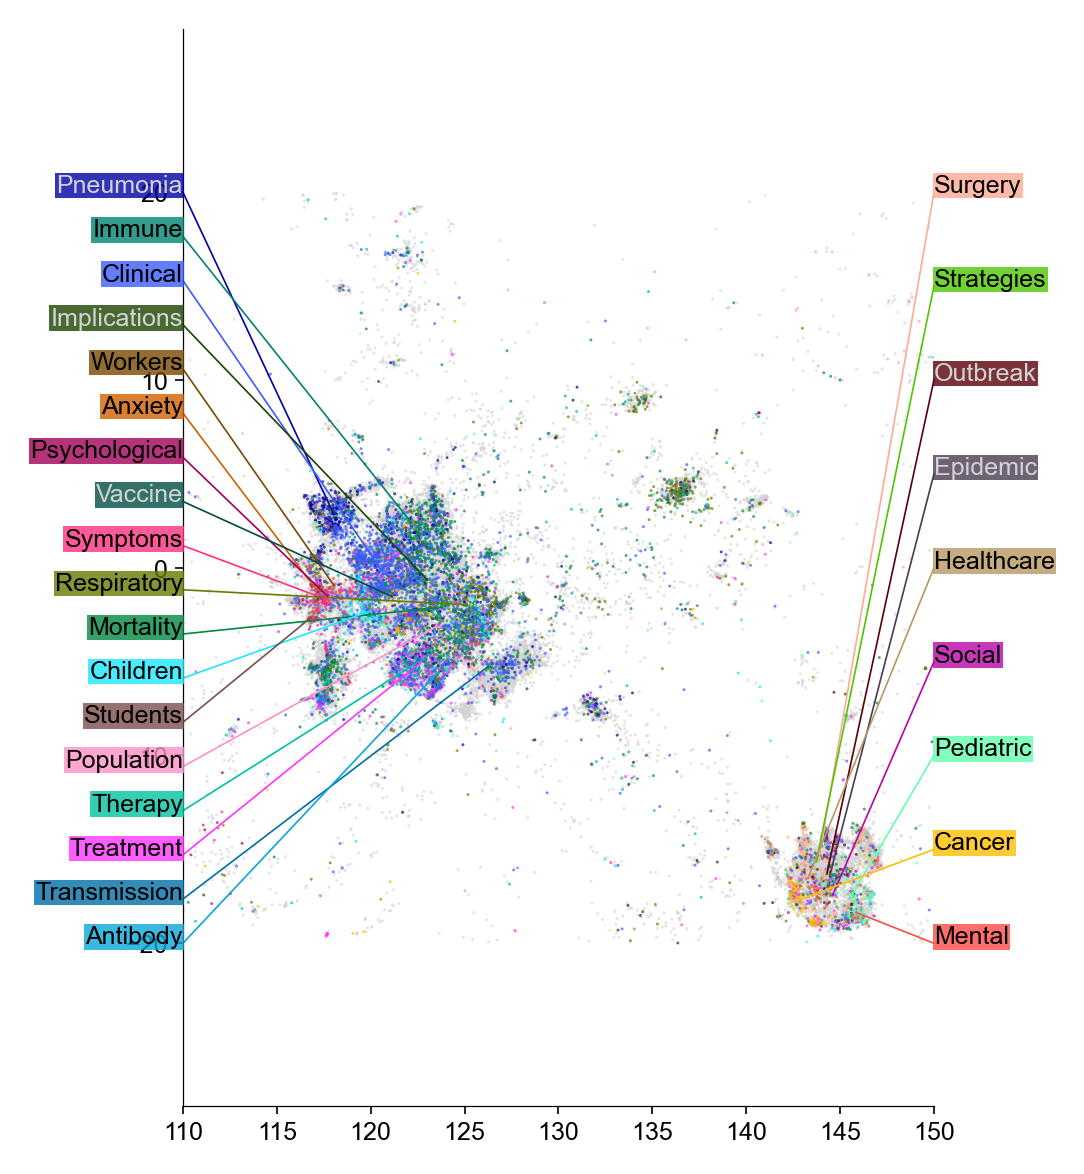

In [71]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.5, 3.8), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

tsne_subregion = tsne_covid[mask_island_3]
colors_subregion = covid_colors[mask_island_3]

right = 150
left = 110
top = 20
bottom = -20

x_lim = (left, right)
y_lim = (bottom, top)

plot_tsne_colors(
    tsne_subregion,
    colors_subregion,
    x_lim,
    y_lim,
    ax=ax,
    plot_type="test",
    axis_on=True,
)
plot_label_tags(
    tsne_subregion,
    colors_subregion,
    covid_legend,
    x_lim,
    y_lim,
    ax=ax,
    middle_value=130,
    fontsize=6,
    subset=False,
)

# fig.savefig(figures_path / "fig_2_covid.png")
# fig.savefig(figures_path / "fig_2_covid.pdf")

In [72]:
# mask island 1
tsne = tsne_rot

right = 132
left = 110
top = 20
bottom = -20

mask_covid_island_3 = (
    mask_covid_2
    & (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

tsne_covid = tsne[mask_covid_2]
mask_island_3 = (
    (tsne_covid[:, 0] < right)
    & (tsne_covid[:, 0] > left)
    & (tsne_covid[:, 1] < top)
    & (tsne_covid[:, 1] > bottom)
)

In [73]:
n = 10
np.random.seed(42)
test = np.random.choice(
    covid_colors[mask_island_3].shape[0], size=n, replace=False
)

for i in test:
    print(clean_2024_df.Title[mask_covid_island_3].iloc[i])
    print(inv_covid_legend[covid_colors[mask_island_3][i]])
    # print(clean_2024_df.AbstractText[mask_covid_island_3].iloc[i])
    print("------------------")

Indirect effect of the COVID-19 pandemic on hospital mortality in patients with hip fracture: a competing risk survival analysis using linked administrative data.
Unlabeled
------------------
Tocilizumab vs. baricitinib in hospitalized severe COVID-19 patients: results from a real-world cohort.
Unlabeled
------------------
Post COVID-19 condition of the Omicron variant of SARS-CoV-2.
Unlabeled
------------------
Factors Associated With Hospitalization Among Breast Cancer Patients With COVID-19: A Diverse Multi-Center Los Angeles Cohort Study.
Cancer
------------------
The Impact of Peripheral Eosinophil Counts and Eosinophil to Lymphocyte Ratio (ELR) in the Clinical Course of COVID-19 Patients: A Retrospective Study.
Clinical
------------------
Interventions for the treatment of persistent post-COVID-19 olfactory dysfunction.
Unlabeled
------------------
Experience in the management of severe COVID-19 patients in an intensive care unit.
Unlabeled
------------------
COVID-19 and vitamin

In [74]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_island_3 = vectorizer.fit_transform(
    clean_2024_df.AbstractText[mask_covid_island_3]
)

vocabulary_island_3 = vectorizer.vocabulary_

CPU times: user 4.17 s, sys: 30.5 ms, total: 4.2 s
Wall time: 4.21 s


In [75]:
inv_vocabulary_island_3 = {v: k for k, v in vocabulary_island_3.items()}

In [76]:
print_tfidf_threshold_words(
    tfidf_island_3,
    inv_vocabulary_island_3,
    np.ones(tfidf_island_3.shape[0], dtype=bool),
    30,
    # several_th=True,
)

There are 30659 papers.


In this threshold there are 30659 papers.
For threshold = 0.10 [1621 1478 1258 1220 1208 1097 1055 1034  987  929  924  920  892  888
  861  849  835  794  793  780  773  771  739  730  717  715  711  706
  702  701]
For threshold = 0.10 ['ct' 'icu' 'group' 'vs' 'children' 'ci' 'pneumonia' 'hr' 'levels' 'meta'
 'il' 'symptoms' 'crp' 'day' 'lung' 'score' 'post' 'chest' 'survivors'
 'serum' 'critical' 'ml' 'rr' 'ards' 'studies' 'prevalence' '001' 'iqr'
 'diabetes' 'dimer']


In [77]:
print_tfidf_top_words(
    tfidf_island_3,
    inv_vocabulary_island_3,
    np.ones(tfidf_island_3.shape[0], dtype=bool),
    50,
)

There are 30659 papers.
TF-IDF:  [0.05212594 0.05117    0.05105162 0.04422317 0.04288227 0.04105272
 0.04096174 0.04010927 0.03908877 0.0359606  0.03263509 0.02896375
 0.02490255 0.02405459 0.02313429 0.02308801 0.02305693 0.02247892
 0.02163294 0.02150576 0.02108121 0.02102756 0.02093831 0.02087081
 0.02073392 0.02022752 0.01994624 0.01975219 0.01968366 0.0196218
 0.01942273 0.01916618 0.01868427 0.01840366 0.01817398 0.01792963
 0.01792082 0.01789769 0.01770007 0.01746802 0.01662588 0.01648605
 0.01639936 0.0163285  0.01621588 0.01617708 0.01599904 0.0159802
 0.01596421 0.01591998]
Words:  ['the' 'and' 'of' 'in' 'patients' 'covid' '19' 'with' 'to' 'were' 'was'
 'for' 'or' 'mortality' '95' 'disease' 'study' 'ci' 'on' 'risk' 'we'
 'severe' 'clinical' 'this' 'from' 'is' 'at' 'associated' 'as' 'had'
 'hospital' 'between' 'that' 'infection' 'sars' 'cov' 'group' 'age'
 'higher' 'by' 'admission' '2020' 'an' 'coronavirus' 'outcomes' 'who' 'be'
 'analysis' 'included' 'compared']
